In [11]:
#!pip install torch fastai

In [107]:
from fastai.vision import *
import fastai
import numpy as np
import pandas as pd
from fastai.vision.all import *
from fastai.vision.data import *
from fastai.vision.data import ImageDataLoaders
from fastai.vision.core import *
import types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

## Dataset CSV Creation

In [82]:
# Clean Dataset
with open('data/list_eval_partition.txt') as f:
    r = f.read().split("\n")[2:]
    r = [i.split() for i in r][:-1]

data = {}
for idx, i in enumerate(r):
    data[i[0]] = [i[1]]
        
# Add bboxes
with open('data/list_bbox.txt') as f:
    r = f.read().split("\n")[2:]
    r = [i.split() for i in r][:-1]
for idx, i in enumerate(r):
    img, bbox = i[0], i[1:]
    data.get(img, []).append(bbox)

# Add category and cid data
with open('data/list_category_img.txt') as f:
    r = f.read().split("\n")[2:]
    r = [i.split() for i in r][:-1]
for idx, i in enumerate(r):
    img, cid = i[0], i[1]
    data.get(img, []).append(cid)

with open('data/list_category_cloth.txt') as f:
    r = f.read().split("\n")[2:]
for key, val in data.items():    
    val.append(r[int(val[-1])-1].split()[0])

In [84]:
# Generate dataframe
img, t, bb, cid, c = [],[],[],[],[]
for key, val in data.items():
    img.append(key)
    t.append(val[0])
    bb.append(val[1])
    cid.append(val[2])
    c.append(val[3])
dd = {'img':img, 'type':t, "bbox": bb, "cid": cid, "category":c}
df = pd.DataFrame(data=dd)

In [89]:
# Generate train, test, val csv
for i in ['train', 'val', 'test']:
    d = df[df['type'] == i]
    path = 'data/{0}.csv'.format(i)
    d.to_csv(path, index=False)

<BarContainer object of 46 artists>

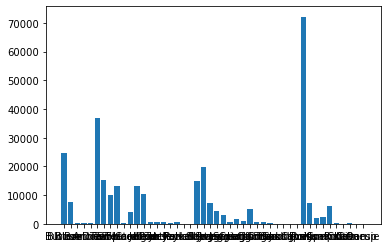

In [93]:
# Plot class distribution
c = Counter(df.category)
plt.bar(c.keys(), c.values())

## Dataset Ingestion

In [117]:
dataset = ImageDataLoaders.from_csv('data', csv_fname='train.csv',
                                 item_tfms=Resize(300),
                                 batch_tfms=aug_transforms(size=224, min_scale=0.9),
                                 valid_pct=0.1,
                                 splitter=RandomSplitter(seed=42),
                                 num_workers=0, label_col=4)

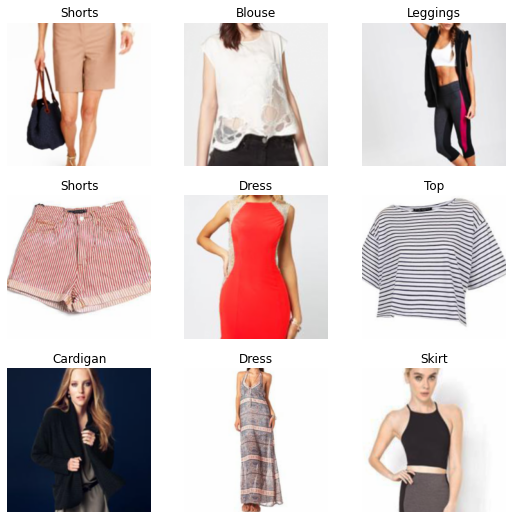

In [118]:
dataset.show_batch()

In [180]:
# Create a custom DataLoader to add in bounding box info
item_tfms = [Resize(300, method='pad'),]
batch_tfms = aug_transforms(size=224, min_scale=0.9)

train_data = pd.read_csv('data/train.csv')
imgs, bbox, bboxlbl = train_data['img'], train_data['bbox'], train_data['category']
dd = {}
for idx,i in enumerate(imgs):
    e  = eval(bbox[idx])
    dd[i] = [[[int(i) for i in e]], [bboxlbl[idx]]]

In [190]:
path = Path('data')
getters = [lambda o:  path/o, lambda o: dd[o][0], lambda o: dd[o][1]]
def get_train_imgs(noop):  return imgs
db = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
               get_items=get_train_imgs,
               getters=getters,
               splitter=RandomSplitter(seed=42),
               item_tfms=item_tfms,
               batch_tfms=batch_tfms,
               n_inp=1)
dls = db.dataloaders(path, num_workers=0)

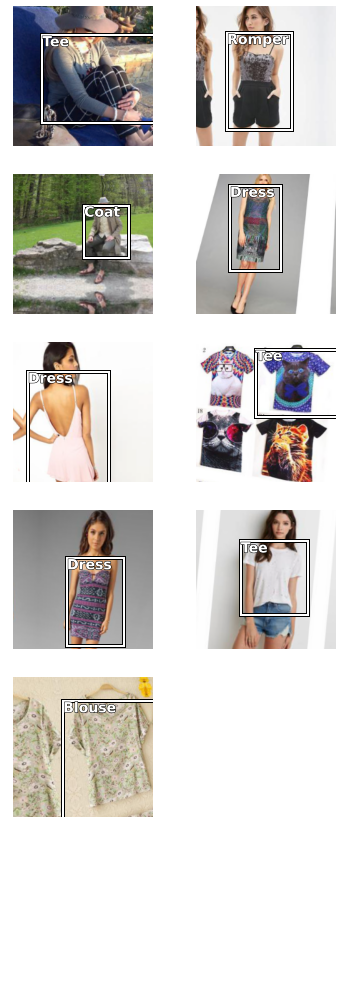

In [192]:
dls.show_batch(nrows=6)

This dataset is too vague due to not having Segmentation masks. Will need proper segmentation masks to do proper background removal

## DeepFashion2 Segmentation Dataset

In [201]:
images, lbl_bbox = get_annotations('data/fs2/deepfashion.py')
img2bbox = dict(zip(images, lbl_bbox))

KeyError: 'categories'

In [137]:
fnames = get_image_files('data/img')

In [203]:
get_annotations??

Signature: get_annotations(fname, prefix=None)
Source:   
def get_annotations(fname, prefix=None):
    "Open a COCO style json in `fname` and returns the lists of filenames (with maybe `prefix`) and labelled bboxes."
    annot_dict = json.load(open(fname))
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list)
    classes = {o['id']:o['name'] for o in annot_dict['categories']}
    for o in annot_dict['annotations']:
        bb = o['bbox']
        id2bboxes[o['image_id']].append([bb[0],bb[1], bb[0]+bb[2], bb[1]+bb[3]])
        id2cats[o['image_id']].append(classes[o['category_id']])
    id2images = {o['id']:ifnone(prefix, '') + o['file_name'] for o in annot_dict['images'] if o['id'] in id2bboxes}
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [(id2bboxes[k], id2cats[k]) for k in ids]
File:      c:\users\sanat\anaconda3.9\lib\site-packages\fastai\vision\core.py
Type:      function


In [227]:
#!pip install pycocotools
from pycocotools.coco import COCO

In [228]:
coco = COCO('data/fs2/deepfashion2.json')

loading annotations into memory...
Done (t=52.28s)
creating index...
index created!


In [229]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
short_sleeved_shirt long_sleeved_shirt short_sleeved_outwear long_sleeved_outwear vest sling shorts trousers skirt short_sleeved_dress long_sleeved_dress vest_dress sling_dress

COCO supercategories: 
clothes


In [247]:
catIds = coco.getCatIds(catNms=['short_sleeved_shirt','skirt']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [1453])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [256]:
path = Path('data/fs2/image')

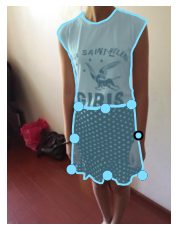

In [251]:
import skimage.io as io
I = io.imread(path/img['file_name'])
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [259]:
CocoDetection?

Object `CocoDetection` not found.


In [261]:
mask = coco.annToMask(anns[0])

In [263]:
MaskBlock(mask)

In [265]:
MaskBlock??

Signature: MaskBlock(codes=None)
Source:   
def MaskBlock(codes=None):
    "A `TransformBlock` for segmentation masks, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodes(codes=codes), batch_tfms=IntToFloatTensor)
File:      c:\users\sanat\anaconda3.9\lib\site-packages\fastai\vision\data.py
Type:      function
